In [87]:
import numpy as np
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report
import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge

print("imported")

imported


In [88]:
# ——— 1) Load & prepare data ———
data    = np.load("threebody_dataset2.npz")

# Drop the last sample on each array
masses  = data["masses"][:-1]                          # (N-1,3)
pos     = data["init_pos"][:-1].reshape(-1, 6)         # (N-1,6)
vel     = data["init_vel"][:-1].reshape(-1, 6)         # (N-1,6)
y       = data["y"][:-1].reshape(-1, 1)                # (N-1,1)

# Now stack into your feature matrix
X       = np.hstack([masses, pos, vel])                # (N-1,15)




In [89]:
# Shuffle, scale, one-hot
rng   = np.random.RandomState(42)
perm  = rng.permutation(len(X))
X, y  = X[perm], y[perm]

In [90]:
scaler    = StandardScaler().fit(X)
X         = scaler.transform(X)
ohe       = OneHotEncoder(sparse_output=False).fit(y)
Y_onehot  = ohe.transform(y)

In [91]:
# 80/20 split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y_onehot, test_size=0.2, random_state=42, stratify=y
)

In [92]:
# wrap as length-1 sequences
X_tr_seqs = [X_train[i:i+1] for i in range(len(X_train))]
Y_tr_seqs = [Y_train[i:i+1] for i in range(len(Y_train))]
X_te_seqs = [X_test[i:i+1]  for i in range(len(X_test))]

In [93]:
# ——— Hyperparameter grid ———
param_grid = {
  "units":              [200, 500, 1000],
  "sr":                 [0.8, 1.2, 1.5],       # spectral radius
  "lr":                 [0.2, 0.5, 1.0],       # leaking rate
  "input_scaling":      [0.5, 1.0, 2.0],
  "rc_connectivity":    [0.1, 0.2],
  "input_connectivity": [0.2, 0.5],
  "ridge":              [1e-8, 1e-6, 1e-4]     # regularization
}

best_score  = -np.inf
best_params = None
best_model  = None

rpy.verbosity(0)
rpy.set_seed(42)

In [94]:
for params in ParameterGrid(param_grid):
    # build the ESN with the correct arg names
    reservoir = Reservoir(
        units=params["units"],
        sr=params["sr"],
        lr=params["lr"],
        input_scaling=params["input_scaling"],
        rc_connectivity=params["rc_connectivity"],
        input_connectivity=params["input_connectivity"],
        seed=42
    )
    readout = Ridge(ridge=params["ridge"])
    model   = reservoir >> readout

    # train on 80%
    model = model.fit(X_tr_seqs, Y_tr_seqs, warmup=0)

    # eval on 20%
    Y_pred = np.vstack(model.run(X_te_seqs)).squeeze()
    y_true = np.argmax(Y_test, axis=1)
    y_hat  = np.argmax(Y_pred,  axis=1)
    acc    = accuracy_score(y_true, y_hat)

    if acc > best_score:
        best_score  = acc
        best_params = params
        best_model  = model
       

print("Completed grid search.")
print(f"Best params: {best_params}")
print(f"Best test accuracy: {best_score:.4f}")


Completed grid search.
Best params: {'input_connectivity': 0.2, 'input_scaling': 2.0, 'lr': 0.5, 'rc_connectivity': 0.2, 'ridge': 1e-08, 'sr': 1.2, 'units': 1000}
Best test accuracy: 0.9833


In [95]:
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# ─── 7) Final ESN test metrics ─────────────────────────────────────────────────
# run the ESN on your test sequences
Y_pred_probs = np.vstack(best_model.run(X_te_seqs)).squeeze()  # (n_test, 3)

# turn probs into hard labels
y_pred = np.argmax(Y_pred_probs, axis=1)
y_true = np.argmax(Y_test,      axis=1)

# compute accuracy
test_acc = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {test_acc * 100:.2f}%\n")

# print the full classification report
labels = [str(c) for c in ohe.categories_[0]]
print(classification_report(
    y_true,
    y_pred,
    target_names=labels
))

Test Accuracy: 96.67%

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        20
           1       1.00      0.90      0.95        20
           2       1.00      1.00      1.00        20

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



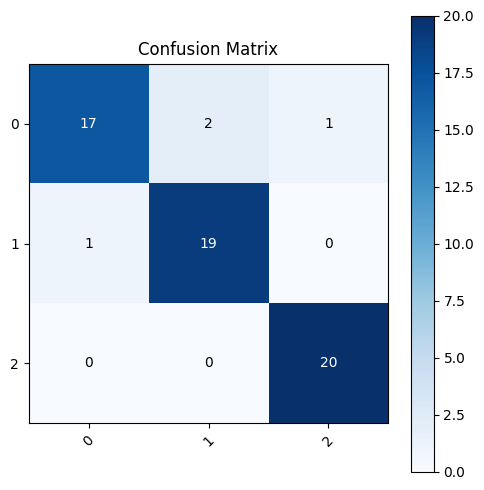

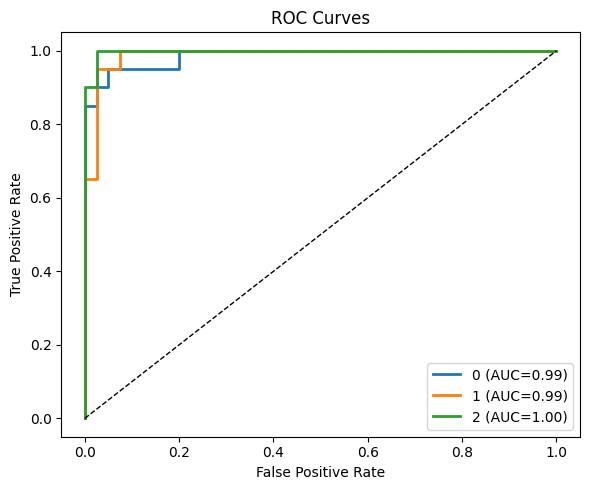

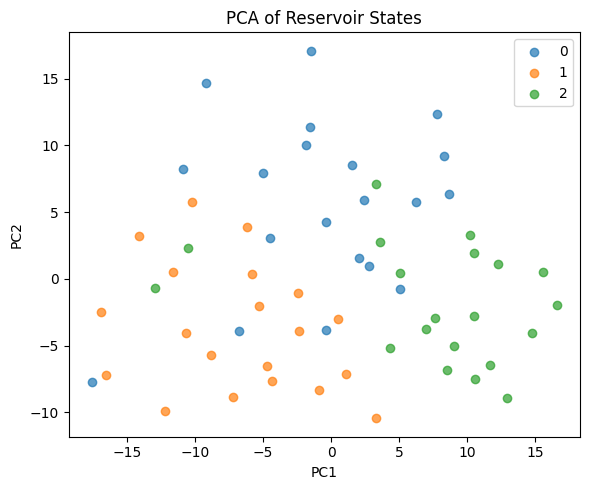

In [96]:
# ─── 6) Analysis plots ─────────────────────────────────────────────────────────
import matplotlib.pyplot as plt
from sklearn.metrics         import confusion_matrix, roc_curve, auc
from sklearn.preprocessing   import label_binarize
from sklearn.decomposition   import PCA
import numpy as np

# prepare labels and probs
n_classes     = Y_pred.shape[1]
labels        = [str(c) for c in ohe.categories_[0]]
y_test        = y_true        # ground‐truth ints 0,1,2…
y_pred        = y_hat         # predicted ints
y_pred_probs  = Y_pred        # soft outputs from your read‐out

# 6a) Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
plt.title("Confusion Matrix")
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.colorbar()
plt.xticks(np.arange(n_classes), labels, rotation=45)
plt.yticks(np.arange(n_classes), labels)
for i in range(n_classes):
    for j in range(n_classes):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i,j]>cm.max()/2 else 'black')
plt.tight_layout()
plt.show()

# 6b) ROC curves (one-vs-rest)
y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))
plt.figure(figsize=(6,5))
for i, lab in enumerate(labels):
    fpr, tpr, _  = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc       = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{lab} (AUC={roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# 6c) PCA scatter of reservoir states
#    we extract the 500‐dim reservoir state for each test sample
reservoir_node = best_model.nodes[0]   # first node is your Reservoir
states = [reservoir_node.run(seq).ravel() for seq in X_te_seqs]
states = np.vstack(states)             # shape = (n_test, units)

pca = PCA(n_components=2, random_state=42)
pcs = pca.fit_transform(states)

plt.figure(figsize=(6,5))
for idx, lab in enumerate(labels):
    mask = (y_test == idx)
    plt.scatter(pcs[mask,0], pcs[mask,1], alpha=0.7, label=lab)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Reservoir States")
plt.legend()
plt.tight_layout()
plt.show()
